## Análisis Exploratorio de los Resultados - ML

En este notebook, presentamos un análisis de los resultados obtenidos por el clasificador de mayoría de votos, con el fin de establecer, con mayor precisión, los resultados financieros esperados para la predicción en condiciones operativas de trading usuales.

In [1]:
#Imports
import pandas as pd
import matplotlib
import numpy as np
import random 
import seaborn as sns
import matplotlib.pyplot as plt # Matplotlib
import operator
matplotlib.style.use('ggplot')
%matplotlib inline


sns.set(rc={"figure.figsize":(3,4)})

### Predicciones

Tomamos la base de datos de los resultados arrjoados por el mejor modelo y realizamos un análisis de las predicciones.

In [2]:
results=pd.read_excel("resultados_best.xlsx")

In [3]:
results.head()

,Unnamed: 0,Date,Hora_COL,Minuto,Hora_NY,Festivo_COL,Festivo_NYSE,Next_Day,Subasta,PFB_ABIERTO,CIB_ABIERTO,Real,Predictions,Spread,Utilidad
0,35504,2022-04-04,16,38,17,False,False,1,0,0,0,0.0,0,0.0,0.0
1,47649,2022-05-05,12,3,13,False,False,0,0,1,1,0.0,0,0.0,0.0
2,10451,2022-01-28,13,5,13,False,False,1,0,1,1,0.0,0,0.0,0.0
3,8782,2022-01-25,12,16,12,False,False,0,0,1,1,0.0,0,0.0,0.0
4,26067,2022-03-10,12,21,12,False,False,0,0,1,1,2.0,0,0.0,0.0


### Filtro periodo Ex-Dividendo

Durante el periodo de muestra, la acción preferencial de Bancolombia y su respectivo ADR presentaron un periodo ex dividendo (periodo en el que la compañía paga dividendos). El periodo ex dividendo para ambos títulos no es el mismo y las predicciones para las condiciones de arbitraje y de spread se ven afectadas por este tipo de evento. Esto ocasiona spreads que reflejan las diferencias entre las fechas de inicio, duración y pago del periodo ex-dividendo para cada instrumento, por lo cual para el análisis financiero de los resultados para las condiciones de arbitraje podemos considerar dos opciones: incluir o eliminar los dividendos del spread observado (sumar o restar el dividendo del spread de la predicción, según sea el caso), o simplemente; eliminar las observaciones del periodo en el cual ambos títulos estuvieron en periodo ex-dividendo.  
Para el análisis de los resultados, lo más conveniente es optar por esta última acción, teniendo en cuenta que el spread observado por dividendos no necesariamente genera utilidades en términos de arbitraje a pesar de que el spread ocasionado por dividendos sí origina spreads de precio entre ambos instrumentos.

In [4]:
#Tamaño de la muestra de predicciones
len(results)

15119

In [5]:
#Filtramos la última semana del mes de Marzo de la predicciones (periodo XD y cierre de libros de conversion.)
xd=results[results['Date'].isin(pd.date_range('2022-03-23','2022-03-31'))]

In [6]:
#Resultados sin periodo ex dividendo
results_xd=results[(results['Date'] <'2022-03-23') | (results['Date']>'2022-03-31')]

#### Spread para las predicciones en el periodo exdividendo versus spread excluyendo exdividendo

Observamos que el spread medio para las predicciones de arbitraje en el periodo exdividendo es sustancialemnte mayor: efecto de la diferencia incorporada en los precios de los instrumentos por la diferencia en las fechas de pago del dividendo entre ambos instrumentos:

In [7]:
#Spread Medio observado en el periodo ex dividendo
xd['Spread'].mean()

259.82793118874656

In [8]:
#Spread medio observado excluyendo el periodo ex dividendo
results_xd['Spread'].mean()

16.39727951594462

### Tratamiento de Festivos

Teniendo en cuenta que al observar spreads durante una fecha festivo, uno de los mercados está cerrado y en la práctica no es posible ejecutar operaciones en todo momento si la predicción así lo indica, el análisis financiero de los resultados en festivos debe hacerse de forma diferencial. Inicialmente, filtramos los festivos de la base y obtenemos los resultados solamente de las predicciones para sesiones de mercado abierto y subastas. Esto reflejará un resultado más preciso y ajustado a las posibilidades prácticas.  
Más adelante observaremos el efecto de la opciones prpactivas en fechas festivo.

In [9]:
#Fitramos los festivos de la base original sin fechas ex dividendo
festivos=results_xd[(results['Festivo_COL']==True) | (results['Festivo_NYSE']==True)]

C:\Users\fract\AppData\Local\Temp\ipykernel_39360\1896804436.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  festivos=results_xd[(results['Festivo_COL']==True) | (results['Festivo_NYSE']==True)]


In [10]:
#Contamos las observaciones en fechas festivo.
festivos['Date'].value_counts()

2022-04-15    175
2022-01-10    173
2022-01-17    168
2022-03-21    162
2022-04-14    154
2022-02-21    151
Name: Date, dtype: int64

In [11]:
#Resultados sin fechas ex dividendo y excluyendo festivos.
results_xd_fest=results_xd[(results_xd['Festivo_COL']== False) & (results_xd['Festivo_NYSE']== False)]

#### Spread para las predicciones en festivos versus spread observado excluyendo festivos

In [12]:
#Spread medio para las predicciones en festivos.
festivos['Spread'].mean()

215.9767225788391

In [13]:
#Spread medio para la predicciones en mercado abierto (excluyendo festivos y periodo ex dividendo).
results_xd_fest['Spread'].mean()

1.3453697007823329

In [14]:
sns.set(rc={"figure.figsize":(7,4)})

In [15]:
#Spread medio en periodo ex dividendo, en festivos, en sesiones de mercados abiertos
[xd['Spread'].mean(), festivos['Spread'].mean(), results_xd_fest['Spread'].mean()]

[259.82793118874656, 215.9767225788391, 1.3453697007823329]

[Text(0, 0.5, 'Spread medio en pesos'),
 Text(0.5, 1.0, 'Spread para las predicciones de arbitraje')]

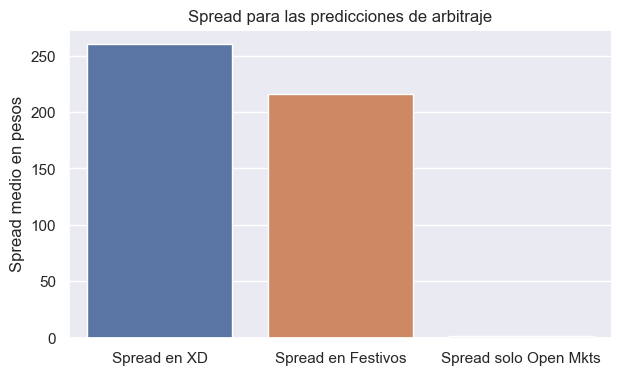

In [16]:
#Comparación entre el spread medio para las predicciones con xd, con festivo y excluyendo ambos
ax=sns.barplot(x=['Spread en XD', 'Spread en Festivos', 'Spread solo Open Mkts'],
            y=[xd['Spread'].mean(), festivos['Spread'].mean(), results_xd_fest['Spread'].mean()])
ax.set(ylabel='Spread medio en pesos', title='Spread para las predicciones de arbitraje')

In [17]:
#Spreads máximos en fechas ex dividendo, en festivos, en sesion abierta de mercados.
[xd['Spread'].max(), festivos['Spread'].max(), results_xd_fest['Spread'].max()]

[1382.614000000001, 2170.759499999993, 320.8802549999964]

[Text(0, 0.5, 'Spread máximo en pesos'),
 Text(0.5, 1.0, 'Spread para las predicciones de arbitraje')]

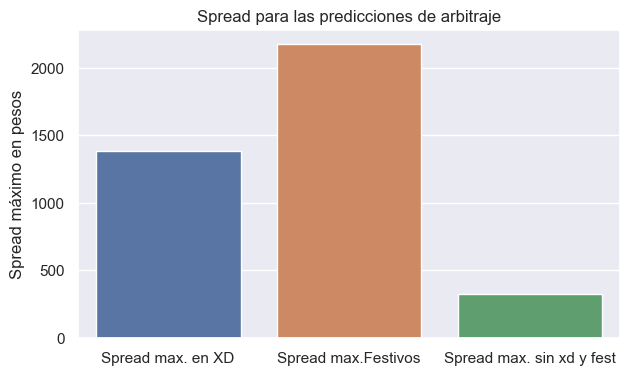

In [18]:
#Spreads máximos para las predicciones con xd, en festivos
ax=sns.barplot(x=['Spread max. en XD', 'Spread max.Festivos', 'Spread max. sin xd y fest'],
            y=[xd['Spread'].max(), festivos['Spread'].max(), results_xd_fest['Spread'].max()])
ax.set(ylabel='Spread máximo en pesos', title='Spread para las predicciones de arbitraje')

### Resultados sesión abierta con subastas

Al eliminar los festivos y las fechas eX dividendo, podremos obtener un análisis inicial que, en la práctica refleja las condiciones más ajustadas a la realidad operativa.

In [19]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [20]:
#Observamos la descripción para los resultados de los trades con predicción positiva (en pesos)
results_xd_fest['Utilidad'].describe()

count      13034.000
mean       13453.697
std       185235.677
min     -2531065.000
25%            0.000
50%            0.000
75%            0.000
max      3208802.550
Name: Utilidad, dtype: float64

In [21]:
#Observamos la descripción para los resultados de los spreads con predicción positiva (en pesos)
results_xd_fest['Spread'].describe()

count   13034.000
mean        1.345
std        18.524
min      -253.107
25%         0.000
50%         0.000
75%         0.000
max       320.880
Name: Spread, dtype: float64

#### Distribución de las predicciones y de los Spreads con predicciones de arbitraje

<AxesSubplot: ylabel='Density'>

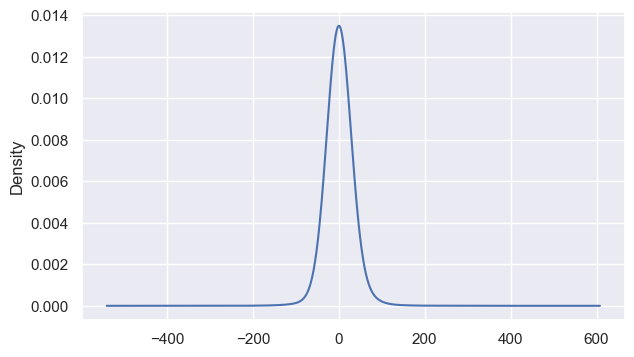

In [22]:
#Densidad del spread para las predicciones
results_xd_fest['Spread'].plot.kde(bw_method=1.5)

<AxesSubplot: ylabel='Frequency'>

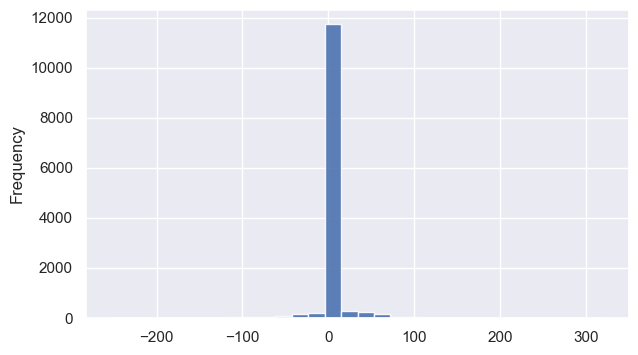

In [23]:
#Histograma de la distrución del spread
results_xd_fest['Spread'].plot.hist(bins=30, alpha=0.9)

<AxesSubplot: ylabel='Frequency'>

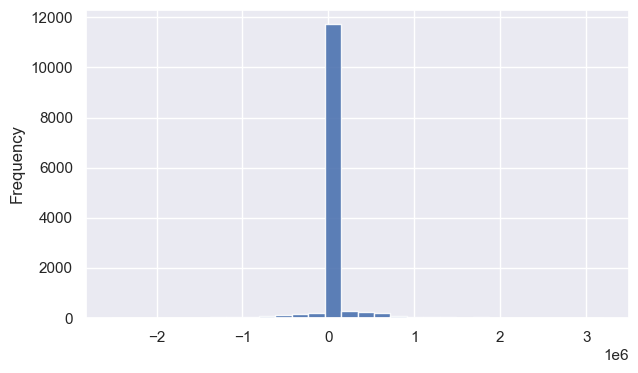

In [24]:
#Histograma de lad istribución de las utilidades
results_xd_fest['Utilidad'].plot.hist(bins=30, alpha=0.9)

<AxesSubplot: ylabel='Density'>

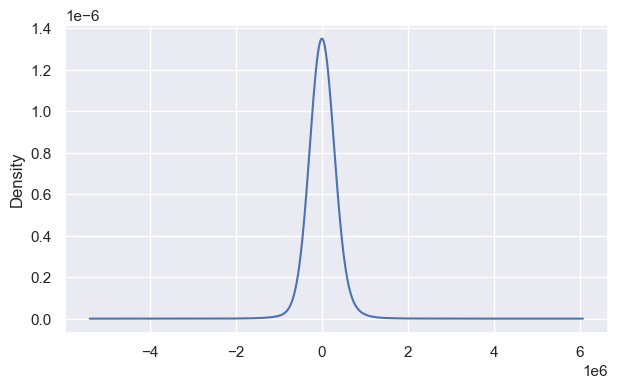

In [25]:
#Función de densidad para las distrubuciones
results_xd_fest['Utilidad'].plot.kde(bw_method=1.5)

In [26]:
#Utilidades netas para las predicciones en condiciones de mercado abierto y subastas de cierre
results_xd_fest['Utilidad'].sum()

175355486.79996926

In [27]:
#Conteo de las predicciones
results_xd_fest['Predictions'].value_counts()

0    11502
2      949
1      583
Name: Predictions, dtype: int64

In [28]:
results_xd_fest['Predictions'].value_counts().index

Int64Index([0, 2, 1], dtype='int64')

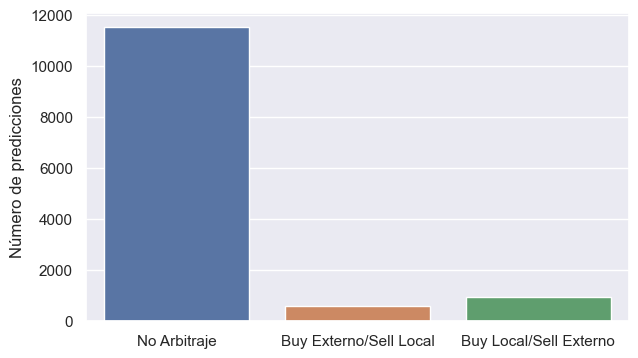

In [29]:
ax=sns.barplot(x=results_xd_fest['Predictions'].value_counts().index,y=results_xd_fest['Predictions'].value_counts().values)
ax.set(ylabel='Número de predicciones')
ax.set_xticklabels(['No Arbitraje','Buy Externo/Sell Local', 'Buy Local/Sell Externo'])
plt.show()

Hasta ahora, los resultados observados muestran que el modelo refleja las condiciones de desbalance de la base original, es decir; la gran mayoría del tiempo predice que no se presentan condiciones de arbitraje. Sin embargo, quisiéramos observar con mayor detalle, lo que habría sucedido si cada vez que el modelo hubiera predicho una condición de arbitraje, se hubiera ejecutado un trade de arbitraje.

#### Pérdidas y ganancias

A partir de las predicciones, clasificamos los trades en nulos, positivos y negativos y observamos los resultados.

In [30]:
results_xd_fest['Trade']=None
for i in range(len(results_xd_fest['Predictions'])):
    if results_xd_fest['Utilidad'].iloc[i]==0:
        results_xd_fest['Trade'].iloc[i]=0
    elif results_xd_fest['Utilidad'].iloc[i]>0:
        results_xd_fest['Trade'].iloc[i]=1
    else:
        results_xd_fest['Trade'].iloc[i]=-1

C:\Users\fract\AppData\Local\Temp\ipykernel_39360\2465336663.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_xd_fest['Trade']=None
C:\Users\fract\AppData\Local\Temp\ipykernel_39360\2465336663.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_xd_fest['Trade'].iloc[i]=0
C:\Users\fract\AppData\Local\Temp\ipykernel_39360\2465336663.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

In [31]:
results_xd_fest['Trade'].value_counts()

 0    11512
 1      928
-1      594
Name: Trade, dtype: int64

In [32]:
trades_positivos=[results_xd_fest['Trade']==1]

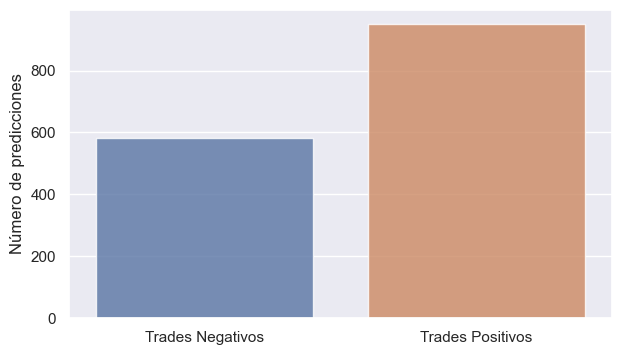

In [33]:
ax=sns.barplot(x=results_xd_fest['Trade'].value_counts().index[1:],y=results_xd_fest['Predictions'].value_counts().values[1:], alpha=0.8)
ax.set(ylabel='Número de predicciones')
ax.set_xticklabels(['Trades Negativos', 'Trades Positivos'])
plt.show()

In [34]:
positivos=results_xd_fest[results_xd_fest['Utilidad']>0]
negativos=results_xd_fest[results_xd_fest['Utilidad']<0]

#### Trades positivos

In [35]:
#Utilidad de los trades positivos
positivos['Utilidad'].sum()

401359479.8999816

In [36]:
#Descripción de los trades positivos
positivos['Utilidad'].describe()

count       928.000
mean     432499.440
std      357328.990
min         949.300
25%      209190.125
50%      372033.950
75%      564563.125
max     3208802.550
Name: Utilidad, dtype: float64

#### Trades negativos

In [37]:
#Pérdidas para los trades negativos
negativos['Utilidad'].sum()

-226003993.1000123

In [38]:
#Descripción para los trades que generan pérdidas
negativos['Utilidad'].describe()

count        594.000
mean     -380478.103
std       347504.755
min     -2531065.000
25%      -535450.000
50%      -296820.000
75%      -123130.750
max         -343.750
Name: Utilidad, dtype: float64

<AxesSubplot: ylabel='Density'>

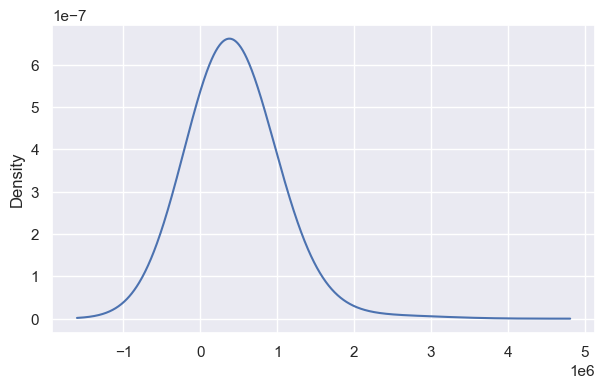

In [39]:
#Función de densidad para las distrubuciones de los trades positivos
positivos['Utilidad'].plot.kde(bw_method=1.5)

<AxesSubplot: ylabel='Density'>

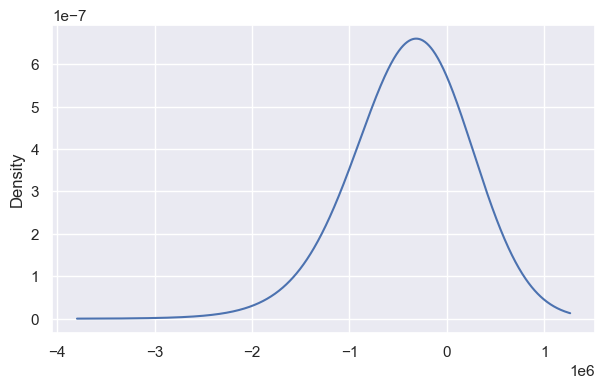

In [40]:
#Función de densidad para las distrubuciones de los trades negativos
negativos['Utilidad'].plot.kde(bw_method=1.5)

<AxesSubplot: ylabel='Frequency'>

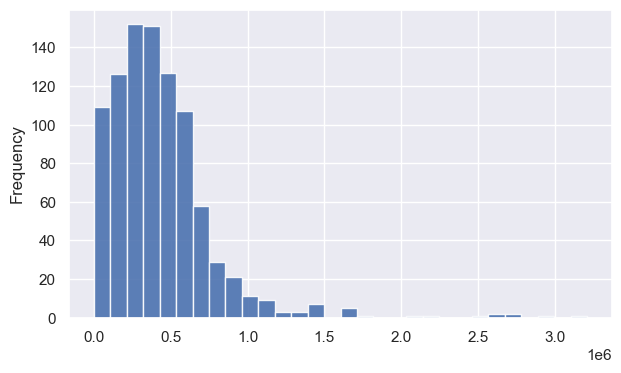

In [41]:
#Histograma de lad istribución de las utilidades
positivos['Utilidad'].plot.hist(bins=30, alpha=0.9)

<AxesSubplot: ylabel='Frequency'>

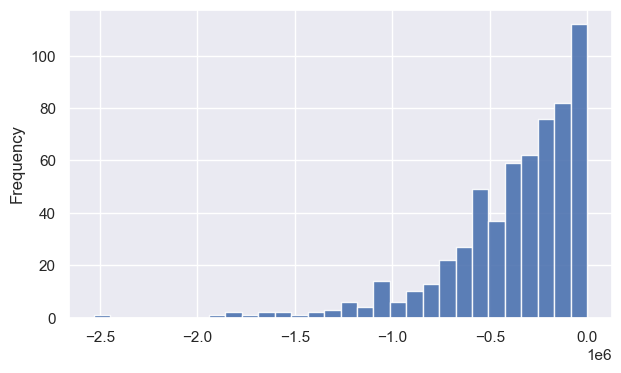

In [42]:
#Histograma de la distribución de las pérdidas
negativos['Utilidad'].plot.hist(bins=30, alpha=0.9)

### Pérdidas y ganancias incluyendo trading en días festivos

Teniendo en cuenta que en los días festivos, alguno de los mercados permanece cerrado, no es posible ejecutar operaciones. No obstante, en la definición de la función de arbitraje, asumimos que en condiciones de días festivos hay arbitraje cuando se observa spread entre el precio de cierre del último día hábil antes del festivo y el precio en el mercado dual que permanece abierto. En este caso, es posible realizar operaciones en el mercado dual que permanece abierto, pero la operación contraria sólo se puede ejecutar al día siguiente en la apertura del nuevo día hábil. Esta condición fue incluida en la función de evaluación financiera. De esta manera, es posible que, durante un día festivo, la predicción indique que se pueden realizar operaciones de arbitraje en todo momento, pero en la práctica esto no es posible de ejecutar.  
Lo usual en la práctica del arbitrador es que, al observar un spread de precio entre los precios de cierre en el mercado cerrado y el precio que se actualiza constantemente en el mercado abierto, se ejecuta una sola operación en el mercado abierto (usualmente al cierre del mercado) y la operación contraria se ejecuta en la apertura del siguiente día hábil en el mercado cerrado por el festivo.  
A continuación incluiremos esta condición operativa en el análisis de resultados y observaremos el efecto de incorporarla en la estrategia de trading, según las predicciones del modelo.

In [43]:
#Contamos las observaciones en fechas festivo.
festivos['Date'].value_counts()

2022-04-15    175
2022-01-10    173
2022-01-17    168
2022-03-21    162
2022-04-14    154
2022-02-21    151
Name: Date, dtype: int64

In [44]:
#Contamos los festivos con predicicones de arbitraje.
festivos_positivos=festivos[results_xd['Predictions']>0]

C:\Users\fract\AppData\Local\Temp\ipykernel_39360\2059271179.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  festivos_positivos=festivos[results_xd['Predictions']>0]


In [45]:
festivos_positivos['Date'].value_counts()

2022-04-15    130
2022-03-21    124
2022-01-10    123
2022-01-17    114
2022-04-14    105
2022-02-21     47
Name: Date, dtype: int64

Para los festivos, tomaremos solo una de las observaciones, aleatoriamente, y observaremos el estado de pérdidas y ganancias.

In [46]:
trades_festivos=[]
PyG_festivos=pd.DataFrame(columns=results.columns)
for fecha in festivos['Date'].value_counts().index:
    obs=results_xd[results_xd['Date']==fecha]
    trade=obs.sample()
    trades_festivos.append(trade['Utilidad'])
    PyG_festivos=pd.concat([PyG_festivos, trade],axis=0)
    
    

C:\Users\fract\AppData\Local\Temp\ipykernel_39360\3153603631.py:7: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  PyG_festivos=pd.concat([PyG_festivos, trade],axis=0)
C:\Users\fract\AppData\Local\Temp\ipykernel_39360\3153603631.py:7: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  PyG_festivos=pd.concat([PyG_festivos, trade],axis=0)
C:\Users\fract\AppData\Local\Temp\ipykernel_39360\3153603631.py:7: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  PyG_festivos=pd.concat([PyG_festivos, trade],axis=0)
C:\Users\fract\AppData\Local\Temp\ipykernel_39360\3153603631.py:7: FutureWarning: In a future version, object-dtype

In [47]:
#Trades simulados en días festivo
PyG_festivos

,Unnamed: 0,Date,Hora_COL,Minuto,Hora_NY,Festivo_COL,Festivo_NYSE,Next_Day,Subasta,PFB_ABIERTO,CIB_ABIERTO,Real,Predictions,Spread,Utilidad
8442,40104,2022-04-15,12,18,13,True,False,0,0,0,1,2.000,2,33.431,334315.000
14182,2827,2022-01-10,12,1,12,True,False,0,0,0,1,1.000,1,541.017,5410167.000
80,5508,2022-01-17,11,42,11,False,True,0,0,1,0,1.000,1,-408.437,-4084368.000
2273,29971,2022-03-21,14,25,15,True,False,1,0,0,1,2.000,2,2065.806,20658057.500
7449,39328,2022-04-14,8,22,9,True,False,0,0,0,0,0.000,0,0.000,0.000
820,18802,2022-02-21,8,16,8,False,True,0,0,0,0,0.000,0,0.000,0.000


In [48]:
PyG_festivos['Utilidad'].describe()

count          6.000
mean     3719695.250
std      8829521.829
min     -4084368.000
25%            0.000
50%       167157.500
75%      4141204.000
max     20658057.500
Name: Utilidad, dtype: float64

In [49]:
trades_festivos_positivos=PyG_festivos[PyG_festivos['Utilidad']>0]
trades_festivos_negativos=PyG_festivos[PyG_festivos['Utilidad']<0]

In [50]:
trades_festivos_positivos['Utilidad'].sum()

26402539.49999999

In [51]:
trades_festivos_negativos['Utilidad'].sum()

-4084368.000000031

### Pérdidas y Ganancias: Mercados abiertos y días festivos

In [52]:
#Sumamos los trade positivos en sesiones abiertas y los trades positivos para días festivos.
#Sumamos los trades negativos en sesiones abiertas y los trades negativos para días festivos.
total_positivos=positivos['Utilidad'].sum()+trades_festivos_positivos['Utilidad'].sum()
total_negativos=negativos['Utilidad'].sum()+trades_festivos_negativos['Utilidad'].sum()

In [53]:
#PyG trades positivos
total_positivos

427762019.3999816

In [54]:
#PyG trades negativos
total_negativos

-230088361.10001233

In [55]:
#PyG neto
PyG_neto=total_positivos+total_negativos
PyG_neto

197673658.2999693

<AxesSubplot: xlabel='PyG Arbitraje'>

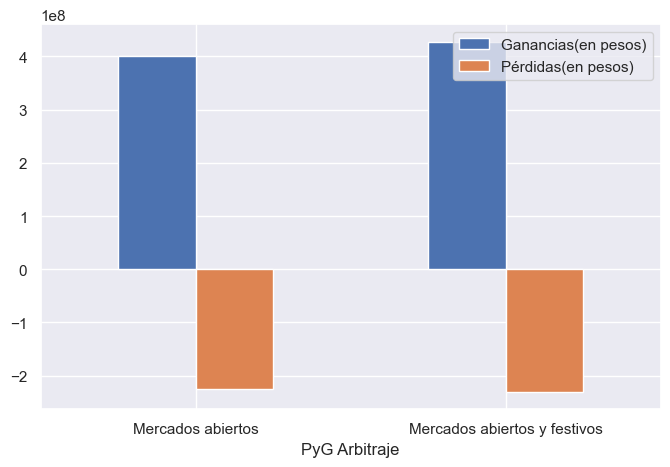

In [56]:
df=pd.DataFrame({
    'PyG Arbitraje':['Mercados abiertos','Mercados abiertos y festivos'],
    'Ganancias(en pesos)':[positivos['Utilidad'].sum(),positivos['Utilidad'].sum()+trades_festivos_positivos['Utilidad'].sum()],
    'Pérdidas(en pesos)':[negativos['Utilidad'].sum(),negativos['Utilidad'].sum()+trades_festivos_negativos['Utilidad'].sum()]
})
df.plot(x='PyG Arbitraje', y=['Ganancias(en pesos)','Pérdidas(en pesos)'],kind='bar',figsize=(8,5), rot=0)
